# Full Audio Spectrogram Classification

### Use Entire Audio Clip Spectrogram to Classify Samples

In [1]:
#import packages
#general 
import pandas as pd
import numpy as np
import itertools
from collections import Counter

#visualization packages
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import Audio
from IPython.display import display

#file reading
import glob
import os

#audio signal processing
from scipy import fftpack
from scipy import signal
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy import signal
import cv2

#modeling
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold

# DataSet

#### Sound Classes (20 X 30s audio samples for each)
* [Fire Alarm](https://www.youtube.com/watch?v=nIfIAgkB-MI)
* Song
    - (5) Folsom Prison Blues - Johnny Cash
    - (5) Cocoa Butter Kisses - Chance the Rapper
    - (5) 3005 - Childish Gambino
    - (5) Alive with the Glory of Love - Say Anything
* Microwave
* Blender
* Vacuum
* Silence


## Read and Collect Audio File Info

In [2]:
#create df to store file labels and paths 
audioInfo_DF = pd.DataFrame(columns = ['label', 'name', 'path'])

#cycle through each folder and wav file
for file in glob.glob('data/*/*.wav'):
    #create DFrow dictionary to hold row information that will be appended
    dfRow = {}
    pathList = file.split('\\')
    dfRow['label'] = pathList[-2]
    dfRow['name'] = pathList[-1]
    dfRow['path'] = file
    #add file label, name, and path to DF
    audioInfo_DF=audioInfo_DF.append(dfRow, ignore_index=True)

audioInfo_DF.head()

,label,name,path
0,alarm,alarm102019_10_06_10_03_49.wav,data\alarm\alarm102019_10_06_10_03_49.wav
1,alarm,alarm12019_10_06_09_54_08.wav,data\alarm\alarm12019_10_06_09_54_08.wav
2,alarm,alarm22019_10_06_09_55_03.wav,data\alarm\alarm22019_10_06_09_55_03.wav
3,alarm,alarm312019_10_07_16_35_07.wav,data\alarm\alarm312019_10_07_16_35_07.wav
4,alarm,alarm32019_10_06_09_55_56.wav,data\alarm\alarm32019_10_06_09_55_56.wav


# Create a Dataset

#### Read each of the wav files, divide them into 3s overlapping windows, and reduce them into a feature set

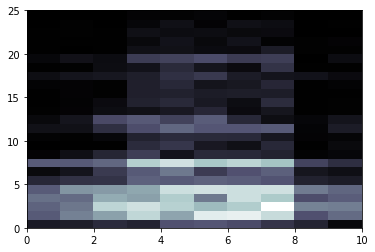

Ellipsis

In [3]:
def loadSpectrogram(idx, timeBins, freqBins, show = False):
    #get read rate and time series amplitude from wav file
    rate, amp = wavfile.read(audioInfo_DF['path'][idx])
    #create spectrogram
    FFT_SIZE=1024
    f,t,spec = signal.spectrogram(amp, nperseg=FFT_SIZE, fs=rate, noverlap=FFT_SIZE/2)
    #filter out frequencies greater than 10 KHZ
    frequencyMask = [True if fr < 10000 else False for fr in f]
    spec = spec[frequencyMask, :]
    
    #using log of amplitudes because it gives more definition to the picture. mimicks decibels scale
    #add 1 to avoid log(0) error
    spec = np.log10(spec + 1)
    
    #resize using bins
    resized_spec=cv2.resize(spec[:,:],(timeBins,freqBins))
    
    if show:
        cmap=plt.cm.bone
        cmap.set_under(color='k', alpha=None)
        plt.pcolormesh(resized_spec,cmap=cmap)
        plt.show()
        
    return resized_spec
    
loadSpectrogram(12, 10, 25, show=True)
...

In [4]:
#create dataset using above functions

X  = []  #holds dataset features
y = [] #holds dataet labels
#read through each of the files in the audioInfo_DF. 
#Read and split the audio files into windows. 
#Create a feature set from each window
for idx in range(len(audioInfo_DF)):
    spec = loadSpectrogram(idx, 10, 25)
    X.append(spec.flatten())
    #add windows label to y list
    y.append(audioInfo_DF['label'][idx])

#convert to numpy and print array sizes
X = np.array(X)
y = np.array(y)
print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (130, 250)
y shape:  (130,)


# Format Dataset and Labels

In [5]:
#normalize feature set
Xnorm = normalize(X)
#encode labels
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=0.33, random_state=42)

# Train Classification Models

In [6]:
#get average accuracy of model using kfold split
def getAccuracy(model, X, y, show=False):
    cv = KFold(n_splits=10)
    scores = []
    
    for train_index, test_index in cv.split(X, y):
        if(show):
            print("Train Index: ", train_index)
            print("Test Index: ", test_index)
        X_train, X_val, y_train, y_val = X[train_index], X[test_index], y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_val, y_val))
    acc = np.mean(scores)
    if show:
        print("Mean accuracy:" + str(acc))
    return acc

In [7]:
#SVM hyperparameter selection

#set hyperparameter lists
cValues = [1e-4, 1e-2, 1, 1e2, 1e4, 1e6, 1e8]
kernels = ['linear', 'poly', 'rbf']
bestSvmModel = None
bestAcc = 0

#get model accuracy for each combination of hyperparameters
for parPair in itertools.product(cValues, kernels):
    model = SVC(C=parPair[0], kernel=parPair[1], gamma='auto')
    acc = getAccuracy(model, X_train, y_train)
    # training info printout
    print("%-20s \t\t acc: %-10s"%(str(parPair), str(round(acc,4)*100)+'%'))
    if acc > bestAcc:
        bestSvmModel = model
        bestAcc = acc

#print best model hyperparameters
print('\n*** Best Model ***')
print("Accuracy: " + str(round(bestAcc,4)*100)+'%')
print("Parameters: " + str(bestSvmModel.get_params))

(0.0001, 'linear')   		 acc: 17.36%    
(0.0001, 'poly')     		 acc: 21.11%    
(0.0001, 'rbf')      		 acc: 17.36%    
(0.01, 'linear')     		 acc: 17.36%    
(0.01, 'poly')       		 acc: 21.11%    
(0.01, 'rbf')        		 acc: 17.36%    
(1, 'linear')        		 acc: 75.83%    
(1, 'poly')          		 acc: 21.11%    
(1, 'rbf')           		 acc: 17.36%    
(100.0, 'linear')    		 acc: 97.78%    
(100.0, 'poly')      		 acc: 21.11%    
(100.0, 'rbf')       		 acc: 66.67%    
(10000.0, 'linear')  		 acc: 97.78%    
(10000.0, 'poly')    		 acc: 21.11%    
(10000.0, 'rbf')     		 acc: 97.78%    
(1000000.0, 'linear') 		 acc: 97.78%    
(1000000.0, 'poly')  		 acc: 21.11%    
(1000000.0, 'rbf')   		 acc: 97.78%    
(100000000.0, 'linear') 		 acc: 97.78%    
(100000000.0, 'poly') 		 acc: 96.67%    
(100000000.0, 'rbf') 		 acc: 97.78%    

*** Best Model ***
Accuracy: 97.78%
Parameters: <bound method BaseEstimator.get_params of SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
    d

In [8]:
# Random Forest hyperparameter selection
#set hyperparameter lists
n = [500]
c = ['gini', 'entropy'] 
maxD = [None,1,5,10,20]
bestRFModel = None
bestAcc = 0

#get model accuracy for each combination of hyperparameters
for parPair in itertools.product(n,c, maxD):
    model = RandomForestClassifier(n_estimators=parPair[0], criterion=parPair[1], max_depth=parPair[2])
    acc = getAccuracy(model, X_train, y_train)
    # training info printout
    print("%-20s \t\t acc: %-10s"%(str(parPair), str(round(acc,4)*100)+'%'))
    if acc > bestAcc:
        bestRFModel = model
        bestAcc = acc

#print best model hyperparameters
print('\n*** Best Model ***')
print("Accuracy: " + str(round(bestAcc,4)*100)+'%')
print("Parameters: " + str(bestRFModel.get_params))

(500, 'gini', None)  		 acc: 94.31%    
(500, 'gini', 1)     		 acc: 56.67%    
(500, 'gini', 5)     		 acc: 93.19%    
(500, 'gini', 10)    		 acc: 93.06%    
(500, 'gini', 20)    		 acc: 94.31%    
(500, 'entropy', None) 		 acc: 95.56%    
(500, 'entropy', 1)  		 acc: 54.44%    
(500, 'entropy', 5)  		 acc: 95.56%    
(500, 'entropy', 10) 		 acc: 94.31%    
(500, 'entropy', 20) 		 acc: 94.31%    

*** Best Model ***
Accuracy: 95.56%
Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>


# Use "unseen" Data for Final Model Test

In [9]:
favModel = bestSvmModel

Confusion matrix, without normalization
Normalized confusion matrix


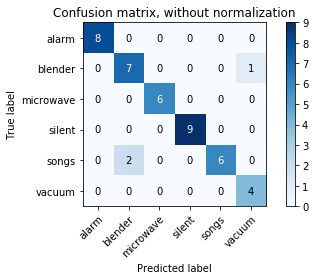

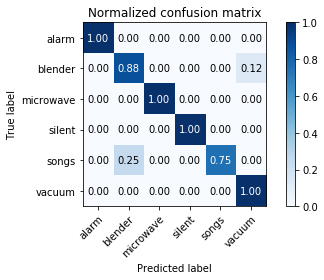

In [10]:
#the code below was taken from an SKLearn tutorial
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#get predicted classes for test dataset
y_pred = favModel.predict(X_test)
class_names = sorted(set(y))


#use sklearn function to print confusion matrixes
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [11]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,alarm,blender,microwave,silent,songs,vacuum,All
True,,,,,,,
alarm,8,0,0,0,0,0,8
blender,0,7,0,0,0,1,8
microwave,0,0,6,0,0,0,6
silent,0,0,0,9,0,0,9
songs,0,2,0,0,6,0,8
vacuum,0,0,0,0,0,4,4
All,8,9,6,9,6,5,43
